In [1]:
import pandas as pd 


In [2]:
df = pd.read_csv("2019-Oct.csv")

EDA

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [5]:
df.isnull().sum()


event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [6]:
df["event_type"].value_counts()


event_type
view        40779399
cart          926516
purchase      742849
Name: count, dtype: int64

In [7]:
df.describe()


,product_id,category_id,price,user_id
count,4.244876e+07,4.244876e+07,4.244876e+07,4.244876e+07
mean,1.054993e+07,2.057404e+18,2.903237e+02,5.335371e+08
std,1.188191e+07,1.843926e+16,3.582692e+02,1.852374e+07
min,1.000978e+06,2.053014e+18,0.000000e+00,3.386938e+07
25%,1.005157e+06,2.053014e+18,6.598000e+01,5.159043e+08
50%,5.000470e+06,2.053014e+18,1.629300e+02,5.296965e+08
75%,1.600030e+07,2.053014e+18,3.585700e+02,5.515788e+08
max,6.050001e+07,2.175420e+18,2.574070e+03,5.662809e+08


In [8]:
df = df.dropna(subset=["user_session"])


In [9]:
df.loc[:, "category_code"] = df["category_code"].fillna("unknown")
df.loc[:, "brand"] = df["brand"].fillna("unknown")

In [10]:
df.to_csv("ecommerce_cleaned.csv", index=False)


In [11]:
df_1 = pd.read_csv("ecommerce_cleaned.csv")

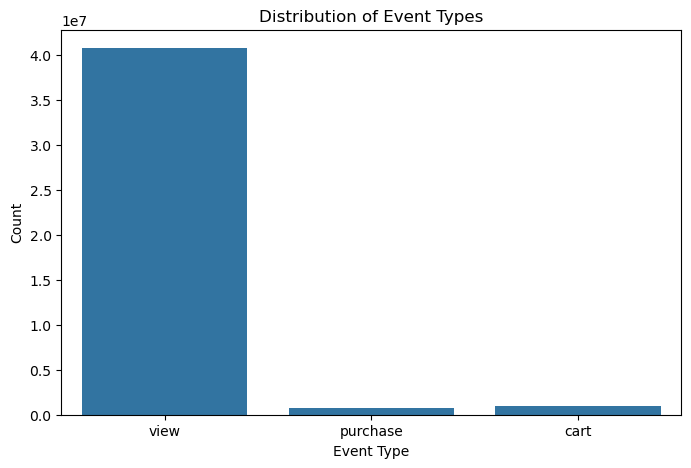

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=df_1["event_type"])
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()


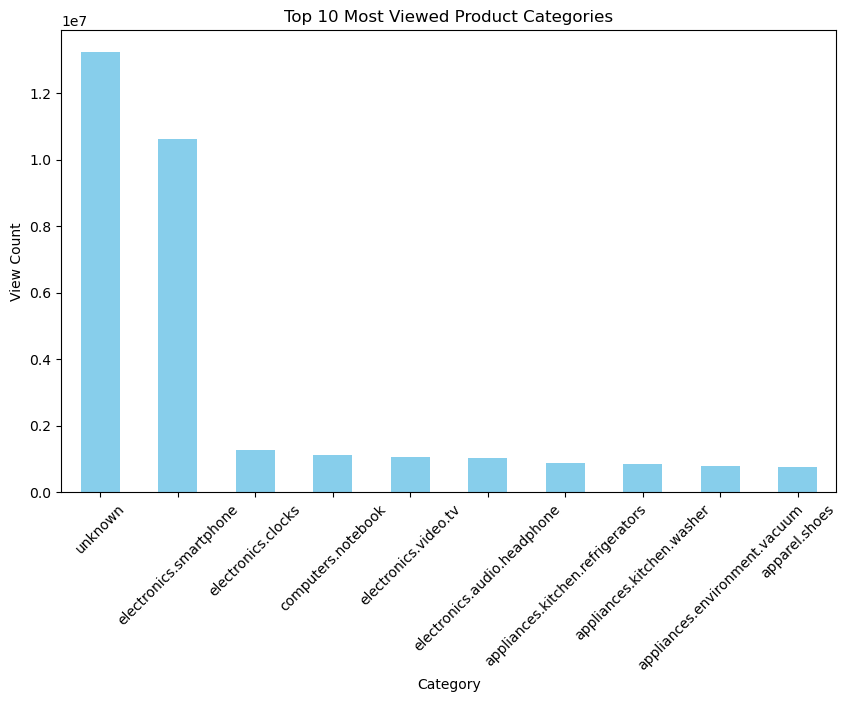

In [13]:
plt.figure(figsize=(10,6))
df_1[df_1["event_type"] == "view"]["category_code"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Most Viewed Product Categories")
plt.xlabel("Category")
plt.ylabel("View Count")
plt.xticks(rotation=45)
plt.show()


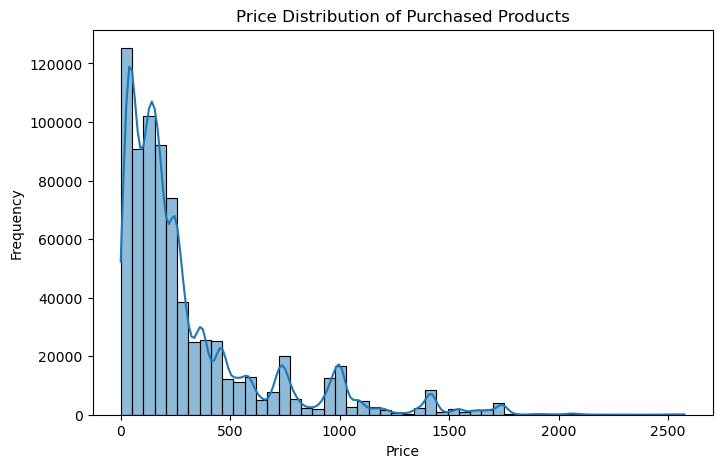

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(df_1[df_1["event_type"] == "purchase"]["price"], bins=50, kde=True)
plt.title("Price Distribution of Purchased Products")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


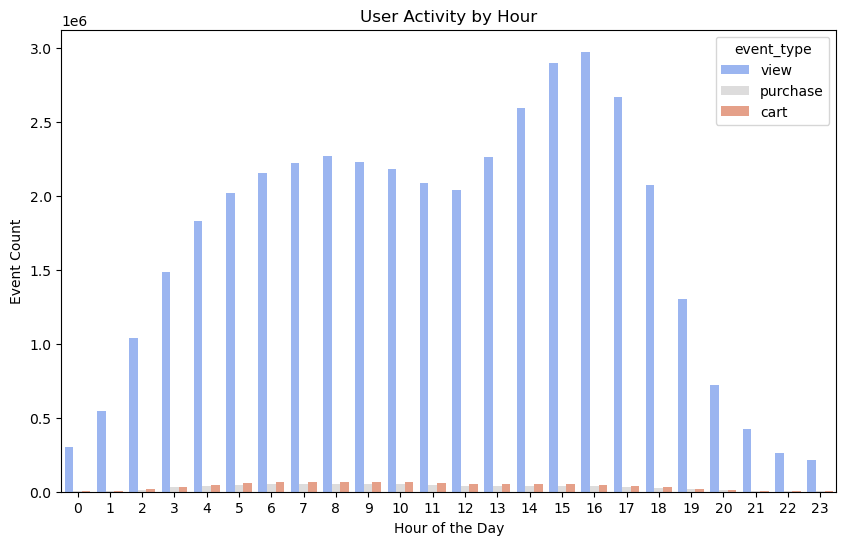

In [15]:
df = df_1.copy()  # Ensures it's an independent DataFrame
df["event_time"] = pd.to_datetime(df["event_time"])
df["hour"] = df["event_time"].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x=df["hour"], hue=df["event_type"], palette="coolwarm")
plt.title("User Activity by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Event Count")
plt.show()


In [16]:
cart_events = df_1[df_1["event_type"] == "cart"].shape[0]
purchase_events = df_1[df_1["event_type"] == "purchase"].shape[0]

conversion_rate = (purchase_events / cart_events) * 100
print(f"Conversion Rate: {conversion_rate:.2f}%")


Conversion Rate: 80.18%


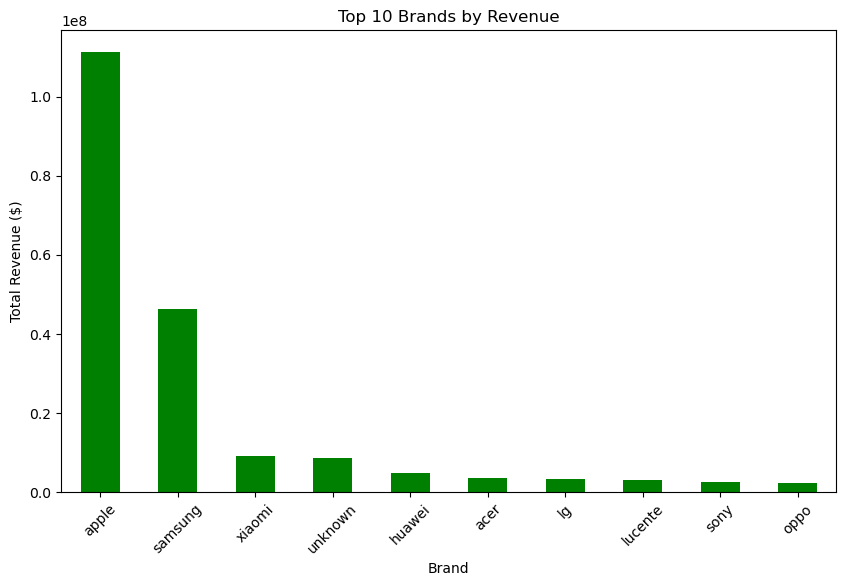

In [17]:
df_purchase = df_1[df_1["event_type"] == "purchase"]

# Group by brand and sum revenue
brand_revenue = df_purchase.groupby("brand")["price"].sum().sort_values(ascending=False).head(10)

# Plot revenue per brand
plt.figure(figsize=(10,6))
brand_revenue.plot(kind="bar", color="green")
plt.title("Top 10 Brands by Revenue")
plt.xlabel("Brand")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.show()


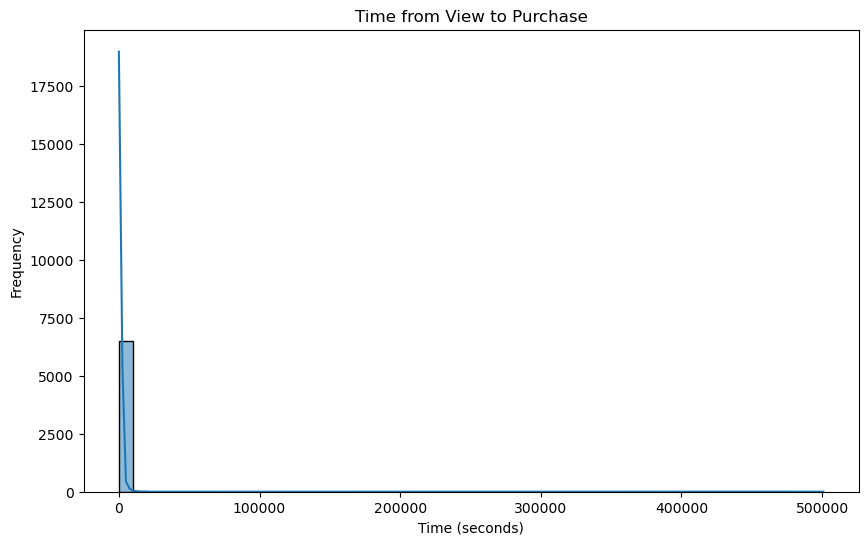

In [18]:
# Sample 5% to test logic without crashing memory
df_sample = df_1.sample(frac=0.05, random_state=42)

df_sample["event_time"] = pd.to_datetime(df_sample["event_time"])
df_sorted = df_sample.sort_values(["user_session", "event_time"])

# Keep only view and purchase rows
views = df_sorted[df_sorted["event_type"] == "view"]
purchases = df_sorted[df_sorted["event_type"] == "purchase"]

# Merge on session
merged = views.merge(purchases, on="user_session", suffixes=("_view", "_purchase"))

# Keep only where view happened before purchase
merged = merged[merged["event_time_view"] < merged["event_time_purchase"]]

# Get first matching pair per session
merged = merged.groupby("user_session").first().reset_index()

# Time difference in seconds
merged["time_diff"] = (merged["event_time_purchase"] - merged["event_time_view"]).dt.total_seconds()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(merged["time_diff"], bins=50, kde=True)
plt.title("Time from View to Purchase")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.show()


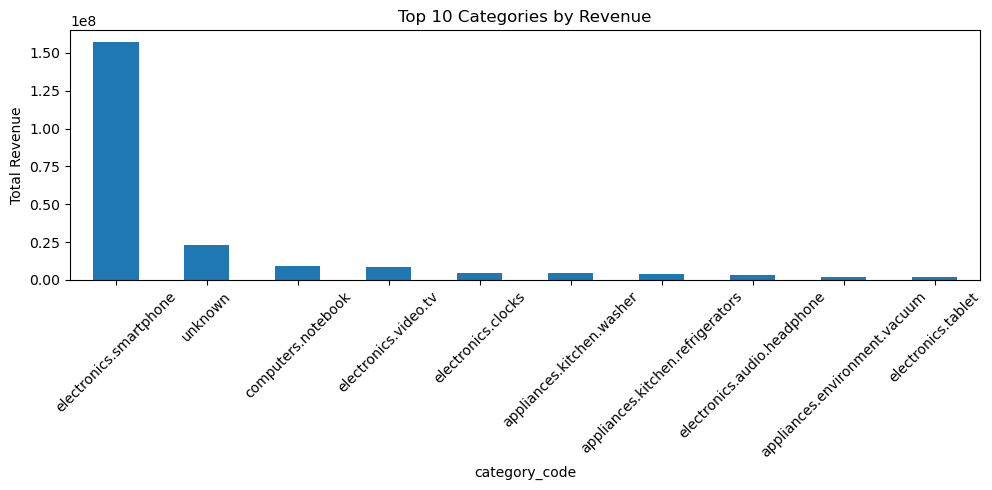

In [19]:
revenue_by_category = df[df["event_type"] == "purchase"].groupby("category_code")["price"].sum().sort_values(ascending=False).head(10)

revenue_by_category.plot(kind="bar", figsize=(10,5), title="Top 10 Categories by Revenue")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


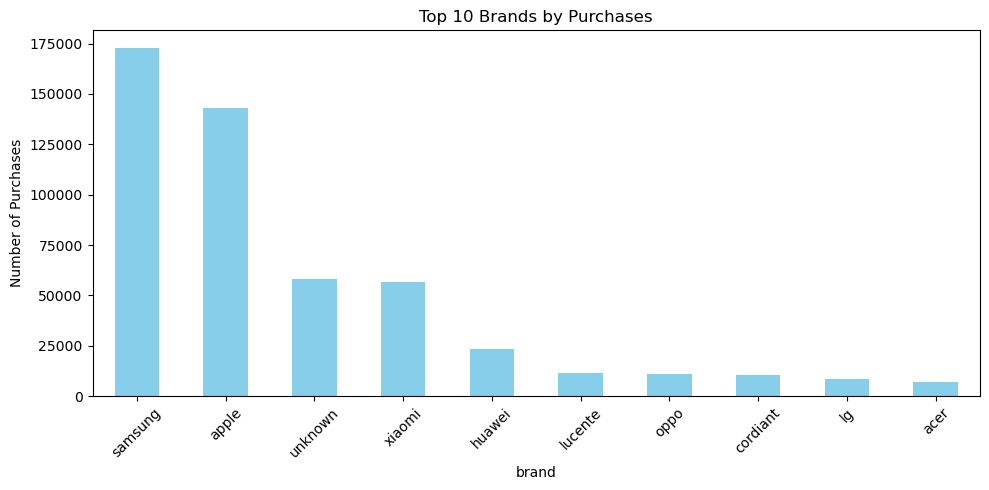

In [20]:
top_brands = df[df["event_type"] == "purchase"]["brand"].value_counts().head(10)

top_brands.plot(kind="bar", figsize=(10,5), title="Top 10 Brands by Purchases", color="skyblue")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


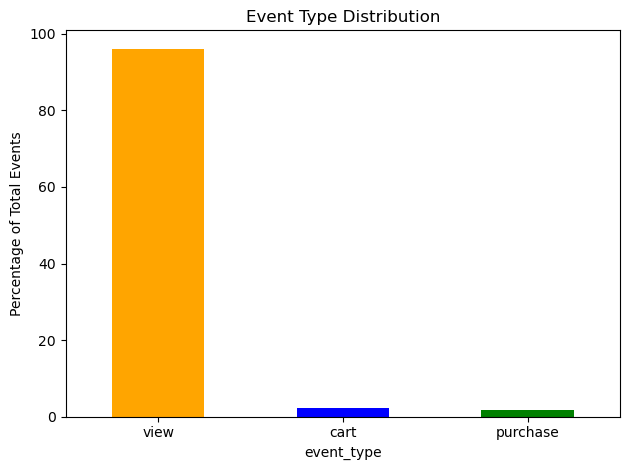

In [21]:
funnel = df["event_type"].value_counts(normalize=True) * 100

funnel.plot(kind="bar", title="Event Type Distribution", color=["orange", "blue", "green"])
plt.ylabel("Percentage of Total Events")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


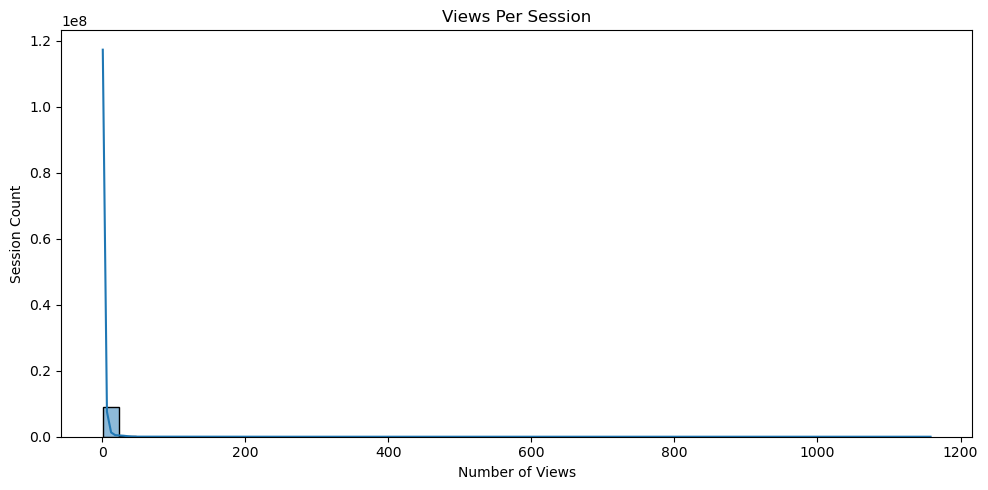

In [22]:
views_per_session = df[df["event_type"] == "view"].groupby("user_session").size()

plt.figure(figsize=(10,5))
sns.histplot(views_per_session, bins=50, kde=True)
plt.title("Views Per Session")
plt.xlabel("Number of Views")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()


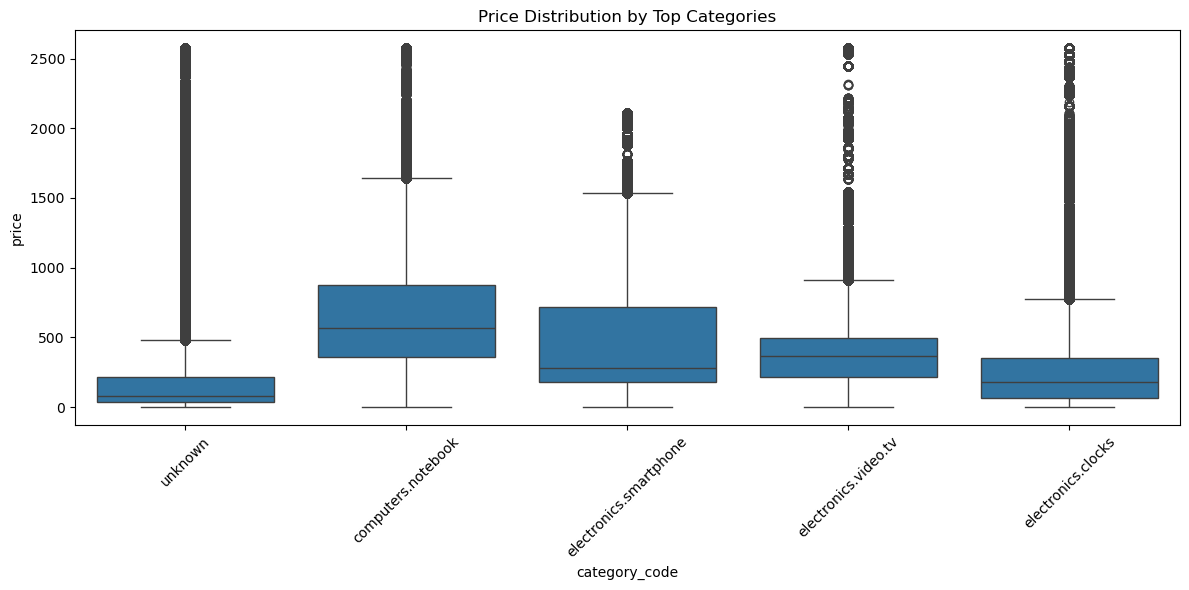

In [23]:
plt.figure(figsize=(12,6))
top_categories = df["category_code"].value_counts().head(5).index
sns.boxplot(data=df[df["category_code"].isin(top_categories)], x="category_code", y="price")
plt.title("Price Distribution by Top Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")


In [25]:
df["hour"] = df["event_time"].dt.hour
df["day_of_week"] = df["event_time"].dt.dayofweek


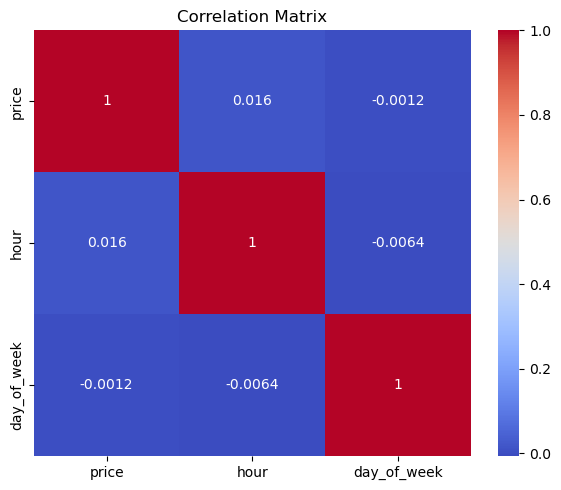

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[["price", "hour", "day_of_week"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


(Session Length)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:

df['event_time'] = pd.to_datetime(df['event_time'])
session_times = df.groupby('user_session')['event_time'].agg(['min', 'max'])
session_times['duration_seconds'] = (session_times['max'] - session_times['min']).dt.total_seconds()



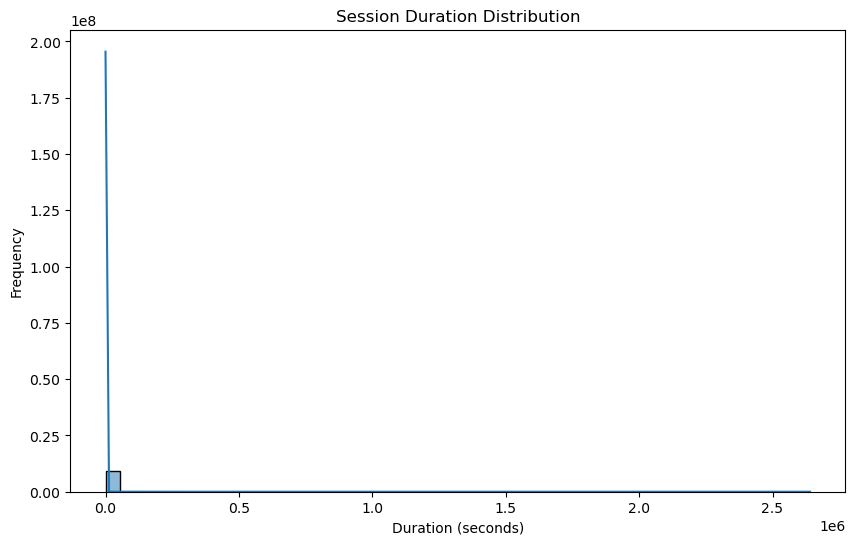

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(session_times['duration_seconds'], bins=50, kde=True)
plt.title("Session Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


Repeat Purchase Users

In [31]:
purchase_users = df[df['event_type'] == 'purchase']
repeat_buyers = purchase_users.groupby('user_id').size().reset_index(name='purchase_count')
repeat_buyers = repeat_buyers[repeat_buyers['purchase_count'] > 1]

print("Repeat Buyers:", len(repeat_buyers))


Repeat Buyers: 131427


Top Products with High View but Low Purchase

In [32]:
views = df[df['event_type'] == 'view'].groupby('product_id').size()
purchases = df[df['event_type'] == 'purchase'].groupby('product_id').size()

view_purchase_df = pd.concat([views, purchases], axis=1)
view_purchase_df.columns = ['views', 'purchases']
view_purchase_df['purchases'].fillna(0, inplace=True)
view_purchase_df['conversion_rate'] = view_purchase_df['purchases'] / view_purchase_df['views']

low_conv_products = view_purchase_df[view_purchase_df['views'] > 100].sort_values('conversion_rate').head(10)
low_conv_products


C:\Users\nandh\AppData\Local\Temp\ipykernel_30020\3855539703.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  view_purchase_df['purchases'].fillna(0, inplace=True)


,views,purchases,conversion_rate
product_id,,,
1003129,635,0.0,0.0
21000015,101,0.0,0.0
59000001,136,0.0,0.0
57800009,135,0.0,0.0
57000009,107,0.0,0.0
56600004,202,0.0,0.0
1002827,1045,0.0,0.0
1002808,173,0.0,0.0
1002724,252,0.0,0.0


User Retention Analysis

In [33]:
user_sessions = df.groupby('user_id')['user_session'].nunique()
retained_users = user_sessions[user_sessions > 1]
print("Users with multiple sessions:", retained_users.count())


Users with multiple sessions: 1546827


Most Popular Product Per Category

In [34]:
popular_per_cat = df[df['event_type'] == 'view'].groupby(['category_code', 'product_id']).size().reset_index(name='count')
popular_per_cat = popular_per_cat.sort_values(['category_code', 'count'], ascending=[True, False])
most_popular = popular_per_cat.groupby('category_code').first().reset_index()

most_popular.head()


,category_code,product_id,count
0,accessories.bag,49800006,3400
1,accessories.umbrella,29700027,792
2,accessories.wallet,28300595,943
3,apparel.belt,28500054,274
4,apparel.costume,55000008,9893


Average Price by Category (Heatmap)

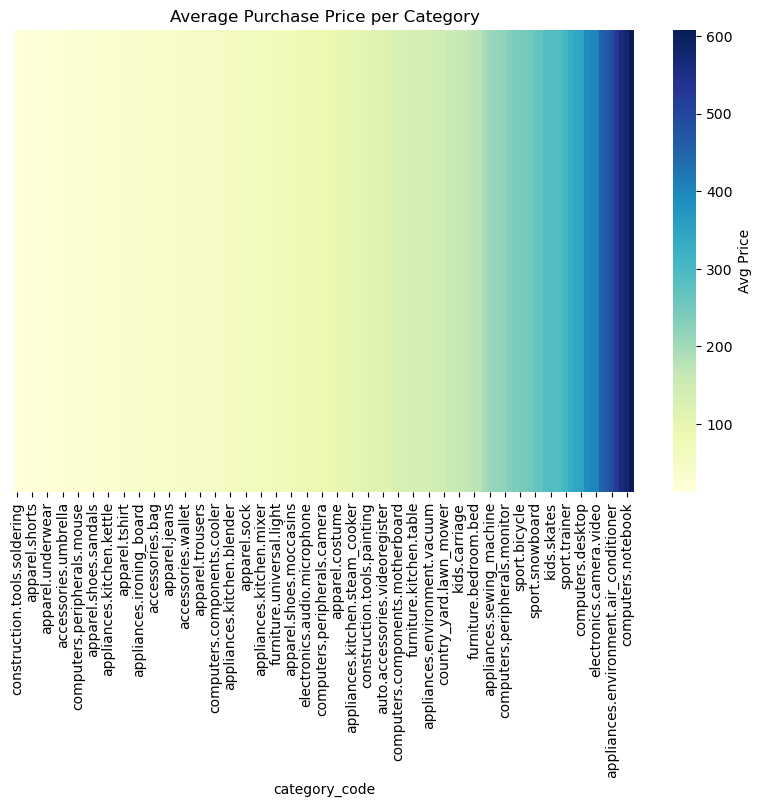

In [35]:
avg_price_cat = df[df['event_type'] == 'purchase'].groupby('category_code')['price'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.heatmap(avg_price_cat.to_frame().T, cmap="YlGnBu", cbar_kws={"label": "Avg Price"})
plt.title("Average Purchase Price per Category")
plt.yticks([])
plt.show()


Top Sessions by Revenue

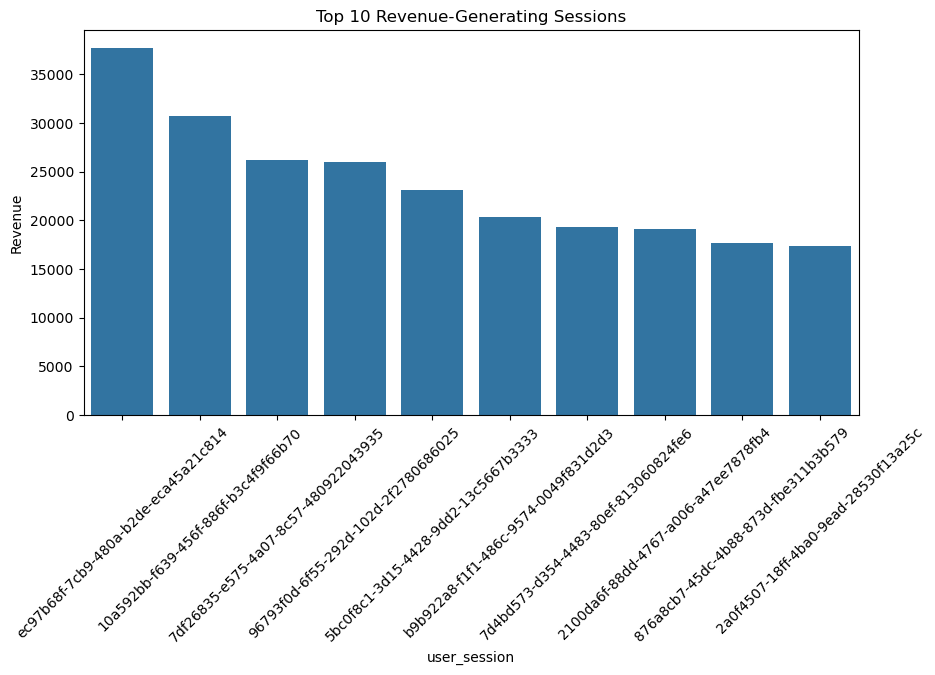

In [36]:
session_revenue = df[df['event_type'] == 'purchase'].groupby('user_session')['price'].sum().sort_values(ascending=False)
top_sessions = session_revenue.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_sessions.index, y=top_sessions.values)
plt.title("Top 10 Revenue-Generating Sessions")
plt.xticks(rotation=45)
plt.ylabel("Revenue")
plt.show()


Brand Popularity vs. Price

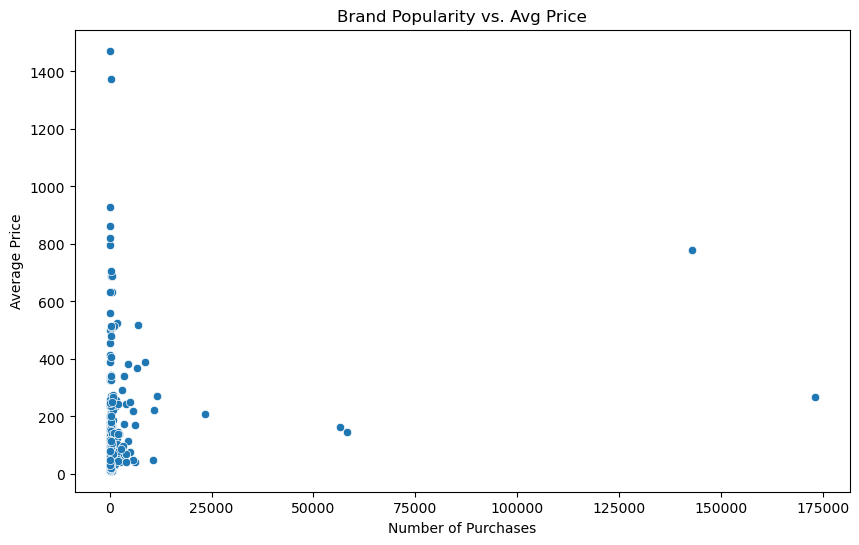

In [37]:
brand_stats = df[df['event_type'] == 'purchase'].groupby('brand').agg({'price': 'mean', 'product_id': 'count'})
brand_stats.columns = ['avg_price', 'purchase_count']
brand_stats = brand_stats[brand_stats['purchase_count'] > 100]  # filter noise

plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_stats, x='purchase_count', y='avg_price')
plt.title("Brand Popularity vs. Avg Price")
plt.xlabel("Number of Purchases")
plt.ylabel("Average Price")
plt.show()
